In [1]:
#imports
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import numpy as np
import cv2
%matplotlib inline
from skimage.feature import hog
import os
import glob
import time
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.svm import LinearSVC # "Support Vector Classifier"

In [2]:
# Define a function to return characteristics of the dataset 
def data_look(fp_list, notfp_list):
    data_dict = {}
    data_dict["n_fps"] = len(fp_list)
    data_dict["n_notfps"] = len(notfp_list)
    fp_img = mpimg.imread(fp_list[0])
    data_dict["image_shape"] = fp_img.shape
    data_dict["data_type"] = fp_img.dtype
    return data_dict

In [3]:
#function to print images
def visualize_images(input_images, num_cols, figure_name, cmap = None):
    fig, axes = plt.subplots((int)((len(input_images) + 1) /num_cols), num_cols, figsize=(24, 20))

    fig = plt.gcf()
    fig.canvas.set_window_title(figure_name)
    
    print(figure_name)
    
    for ax, image in zip(axes.flat, input_images):
        if(cmap == "gray" or cmap == 'hot'):
            ax.imshow(image, cmap=cmap)
        elif(image.shape[2]==1):
            ax.imshow(image[:,:,0], cmap = cmap)
        else:
            ax.imshow(image, cmap=cmap)

    plt.show()

In [4]:
#Read fps i.e. fishplates and not-fps i.e. non-fishplate images

#Data folders
fishplate_dir =     'C:/Users/hp/Desktop/Mod1-IITR/fishplate - Copy/pos/'
non_fishplate_dir = 'C:/Users/hp/Desktop/Mod1-IITR/fishplate - Copy/neg/'

# images are divided up into fishplate and non-fishplate
fps = []
notfps = []

# Read fishplate images
images = glob.iglob(fishplate_dir + '*.jpg', recursive=True)
for image in images:
        fps.append(image)
        
# Read non-fishplate images
images = glob.iglob(non_fishplate_dir + '*.jpg', recursive=True)
for image in images:
        notfps.append(image)
    
data_info = data_look(fps, notfps)

print('Your function returned a count of', data_info["n_fps"], 'fps and', data_info["n_notfps"], 'nonfps')
print('Size: ',data_info["image_shape"], ' and data type:', data_info["data_type"])

Your function returned a count of 66 fps and 66 nonfps
Size:  (100, 100, 3)  and data type: uint8


Example fp images


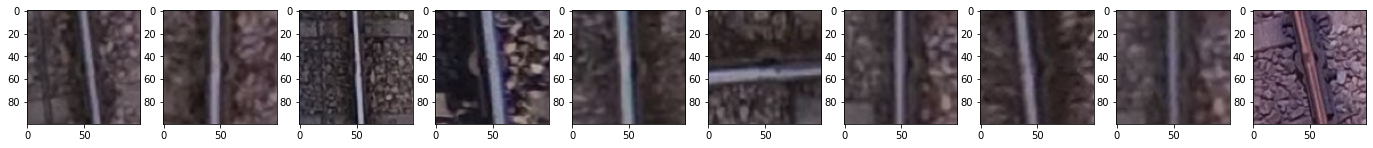

Example not-fp images


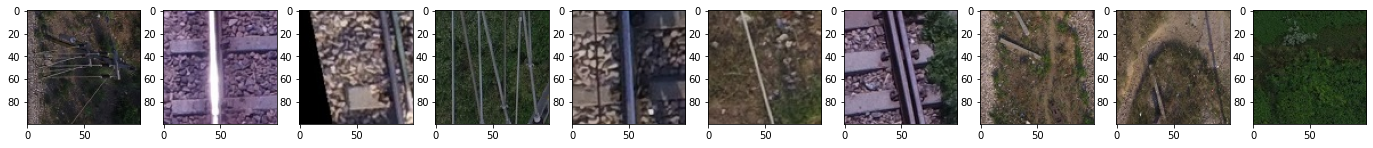

In [5]:
#Visualize some input images
import random

num_images = 10

# Just for fun choose random fp / not-fp indices and plot example images   
fps_samples = random.sample(list(fps), num_images)
notfp_samples = random.sample(list(notfps), num_images)
    
# Read in fp / not-fp images
fp_images = []
notfp_images = []
for sample in fps_samples:
    fp_images.append(mpimg.imread(sample))
    
for sample in notfp_samples:
    notfp_images.append(mpimg.imread(sample))

visualize_images(fp_images, num_images, "Example fp images")
visualize_images(notfp_images, num_images, "Example not-fp images")

Text(0.5, 1.0, 'YUV')

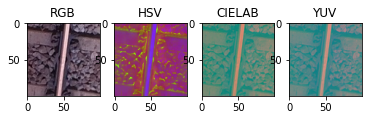

In [6]:
#Plot the examples of colour spaces on 1 image
img = cv2.imread('C:/Users/hp/Desktop/Mod1-IITR/fishplate/pos/40.jpg')
plt.subplot(141)
plt.imshow(img)
plt.title('RGB')
plt.subplot(142)
hsv = cv2.cvtColor(img, cv2.COLOR_BGR2HSV) 
plt.imshow(hsv) 
plt.title('HSV')
plt.subplot(143)
lab = cv2.cvtColor(img, cv2.COLOR_BGR2LAB) 
plt.imshow(lab)
plt.title('CIELAB')
plt.subplot(144)
yuv = cv2.cvtColor(img, cv2.COLOR_BGR2YUV)
plt.imshow(yuv) 
plt.title('YUV')

In [7]:
from skimage.feature import hog

def get_hog_features(img, orient, pix_per_cell, cell_per_block, vis=False, feature_vec=True):
    if vis == True:
        features, hog_image = hog(img, orientations=orient, pixels_per_cell=(pix_per_cell, pix_per_cell),
                                  cells_per_block=(cell_per_block, cell_per_block), transform_sqrt=True, 
                                  visualize=vis, feature_vector=feature_vec)
        return features, hog_image
    # Otherwise call with one output
    else:      
        features = hog(img, orientations=orient, pixels_per_cell=(pix_per_cell, pix_per_cell),
                       cells_per_block=(cell_per_block, cell_per_block), transform_sqrt=True, 
                       visualize=vis, feature_vector=feature_vec)
        return features

Text(0.5, 1.0, 'not fp HOG')

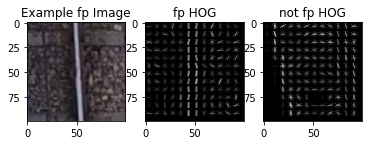

In [8]:
orient = 9
pix_per_cell = 8
cell_per_block = 2

fp_features, hog_image = get_hog_features(cv2.cvtColor(fp_images[1], cv2.COLOR_RGB2GRAY), orient, pix_per_cell, cell_per_block, 
                        vis=True, feature_vec=True)

notfp_features, notfp_hog_image = get_hog_features(cv2.cvtColor(notfp_images[2], cv2.COLOR_RGB2GRAY), orient, pix_per_cell, cell_per_block, 
                        vis=True, feature_vec=True)

# Plot the examples
fig = plt.figure()
plt.subplot(131)
plt.imshow(fp_images[2])
plt.title('Example fp Image')
plt.subplot(132)
plt.imshow(hog_image, cmap='gray')
plt.title('fp HOG')
plt.subplot(133)
plt.imshow(notfp_hog_image, cmap='gray')
plt.title('not fp HOG')

In [9]:
def bin_spatial(img, size=(16, 16)):
    color1 = cv2.resize(img[:,:,0], size).ravel()
    color2 = cv2.resize(img[:,:,1], size).ravel()
    color3 = cv2.resize(img[:,:,2], size).ravel()
    return np.hstack((color1, color2, color3))

In [10]:
# Define a function to compute color histogram features 
def color_hist(img, nbins=32, bins_range=(0, 256)):
    # Compute the histogram of the color channels separately
    channel1_hist = np.histogram(img[:,:,0], bins=nbins, range=bins_range)
    channel2_hist = np.histogram(img[:,:,1], bins=nbins, range=bins_range)
    channel3_hist = np.histogram(img[:,:,2], bins=nbins, range=bins_range)
    # Concatenate the histograms into a single feature vector
    hist_features = np.concatenate((channel1_hist[0], channel2_hist[0], channel3_hist[0]))
    # Return the individual histograms, bin_centers and feature vector
    return hist_features

In [11]:
#the following code is for finding HOG using code #1  : features.py
def get_hog_features(img, orient, pix_per_cell, cell_per_block, vis=False,transform_sqrt=True, feature_vec=True):
    if vis == True:
        features, hog_image = hog(img, orientations=orient, pixels_per_cell=(pix_per_cell, pix_per_cell),
            cells_per_block=(cell_per_block, cell_per_block), transform_sqrt=True,
            visualize=True, feature_vector=False)
        return features, hog_image
    else:
        features = hog(img, orientations=orient, pixels_per_cell=(pix_per_cell, pix_per_cell),
            cells_per_block=(cell_per_block, cell_per_block), transform_sqrt=True,
            visualize=False, feature_vector=feature_vec)
        return features

In [12]:
def search_windowfeature(image2,color_space='RGB',orient=16,pix_per_cell=16, cell_per_block=2):       
        test_img = cv2.cvtColor(window,cv2.COLOR_RGB2GRAY)    
        hogfeaturestest, hog_imagetest = get_hog_features(test_img, orient,pix_per_cell, cell_per_block,vis=True,transform_sqrt=True,feature_vec=True,)
        featuresizetest=hogfeaturestest.size
        hogfeaturestest=np.reshape(hogfeaturestest,(featuresizetest,),order='C')
        hogfeaturestest= hogfeaturestest.reshape(1,-1)
        return hogfeaturestest    


In [13]:
def sliding_window(image, stepSize, windowSize):
    # slide a window across the image
    for y in range(0, image.shape[0], stepSize):
        for x in range(0, image.shape[1], stepSize):
            # yield the current window
            yield (x, y, image[y:y + windowSize[1], x:x + windowSize[0]])

In [14]:
color_space = 'HSV' # Can be RGB, HSV, LUV, HLS, YUV, YCrCb
orient = 9  # HOG orientations
pix_per_cell = 16 # HOG pixels per cell
cell_per_block = 2 # HOG cells per block
hog_channel = 'ALL' # Can be 0, 1, 2, or "ALL"
spatial_size = (32, 32) # Spatial binning dimensions
hist_bins = 16    # Number of histogram bins
spatial_feat = True # Spatial features on or off
hist_feat = True # Histogram features on or off
hog_feat = True # HOG features on or off
y_start_stop = [300, 500] # Min and max in y to search in slide_window()

In [15]:
if __name__ == '__main__':
    posfeatures=[]
    h1=[]
    positive= 'C:/Users/hp/Desktop/Mod1-IITR/fishplate - Copy/pos/'
    for image_file in os.listdir(positive):
        image = mpimg.imread(os.path.join(positive,image_file))

        gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
        gray=np.resize(gray,(100,100))
        
        hogfeatures, hog_image = get_hog_features(gray, orient=9,pix_per_cell=16, cell_per_block=2,vis=True,transform_sqrt=True,feature_vec=True,)
        featuresize=hogfeatures.size
        hogfeatures=np.reshape(hogfeatures,(featuresize,),order='C')
        hogfeatures= hogfeatures.reshape(1,-1)
        posfeatures.append(hogfeatures)
        tpos=np.concatenate(posfeatures)  
        h1.append(np.concatenate(posfeatures))

    negfeatures=[]
    h2=[]
    negative= 'C:/Users/hp/Desktop/Mod1-IITR/fishplate - Copy/neg/'
    for image_file1 in os.listdir(negative):
        image1 = mpimg.imread(os.path.join(negative,image_file1))

        gray1 = cv2.cvtColor(image1, cv2.COLOR_RGB2GRAY)
        gray1=np.resize(gray1,(100,100))
        
        hogfeatures1, hog_image1 = get_hog_features(gray1, orient=9,pix_per_cell=16, cell_per_block=2,vis=True,transform_sqrt=True,feature_vec=True,)
        featuresize1=hogfeatures1.size
        hogfeatures1=np.reshape(hogfeatures1,(featuresize1,),order='C')
        hogfeatures1= hogfeatures1.reshape(1,-1)

        negfeatures.append(hogfeatures1)
        t=np.concatenate(negfeatures)  
        h2.append(np.concatenate(negfeatures))
    
#SVM classification 
# svc = LinearSVC()
# X_scaler = StandardScaler() 
# X = np.vstack((tpos,t))
# X_scaler.fit(X)
# scaled_X = X_scaler.transform(X)
# y = np.hstack((np.ones(len(tpos)), np.zeros(len(t))))
# X_train, X_test, y_train, y_test = train_test_split(scaled_X, y, test_size=0.2, random_state=0)

# # Check the training time for the SVC
# time1=time.time()
# svm_model_linear =svc.fit(X_train, y_train)
# t2 = time.time()

# print(round(t2-time1, 2), 'Seconds to train SVC...')
# svm_predictions = svm_model_linear.predict(X_test)
# svm_predictions = svc.predict(X_test)
# print('Test Accuracy of SVC = ',round(svm_model_linear.score(X_test, y_test),4)) 

X = np.vstack((tpos, t))
y = np.hstack((np.ones(len(tpos)), np.zeros(len(t))))
svc = LinearSVC()
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
svm_model_linear=svc.fit(X_train, y_train)
svm_predictions = svm_model_linear.predict(X_test)
svm_predictions = svc.predict(X_test)
print('Test Accuracy of SVC = ',round(svm_model_linear.score(X_test, y_test),4)) 

imdir = 'C:/Users/hp/Desktop/Mod1-IITR/test317/'
xcord=[]
ycord1=[]
(winW, winH) = (100,100)
counter = 0
for image_file in os.listdir(imdir):
    image2 = mpimg.imread(os.path.join(imdir, image_file))
    on_windows=[]
    pred=[]
    clone = image2.copy()
    clone = clone*255
    for (x, y, window) in sliding_window(image2, stepSize=100, windowSize=(winW, winH)): # change stepsize for more accuracte results , higher stepsize-> lower time/faster and vice versa
        if window.shape[0] != winH or window.shape[1] != winW:
            continue
        windowstestfeat = search_windowfeature(window,color_space=color_space,orient=orient, pix_per_cell=pix_per_cell,cell_per_block=cell_per_block) 
        testfeaturesh = windowstestfeat
        prediction =svm_model_linear.predict(testfeaturesh) 
        pred.append(prediction)
        if prediction[0]==1:
            on_windows.append(window)
            xcord.append(x)
            ycord1.append(y)
            cv2.rectangle(clone, (x, y), (x + winW, y + winH), (0, 255, 0), 2) #drawing rectangles
            cv2.imshow("Window",clone) #showing image
#             cv2.rectangle(clone, (x, y), (x + winW, y + winH), (0, 0, 255), 2) #red box for final box
#             pth = 'fpblack/74/'+str(counter)+".jpg"
#             cv2.imwrite(pth, clone)
#             cv2.rectangle(clone, (x, y), (x + winW, y + winH), (0, 255, 0), 2) #reverting changes
        counter+=1
        k=cv2.waitKey(1)
        
    cv2.imwrite('317rhoggg.png', clone)    # for saving the image after the prediction of the whole image

Test Accuracy of SVC =  0.8148


In [16]:
actual = np.zeros(counter)

# 317
# actual[148]=1
# actual[152]=1 #uncomment and add 1 to boxes where fishplate is present


# 74
# actual[98]=1

# 30
# actual[174]=1
# actual[178]=1


# 359r
# actual[29]=1
# actual[131]=1
# actual[115]=1

Accuracy: 0.9444444444444444
Precision: 0.0
Recall 0.0
Senstivity: nan
Specificity: 0.9444444444444444


c:\users\hp\appdata\local\programs\python\python38-32\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
<ipython-input-17-5b9f1e876c41>:11: RuntimeWarning: invalid value encountered in longlong_scalars
  print("Senstivity:",(tp/(tp+fn)))


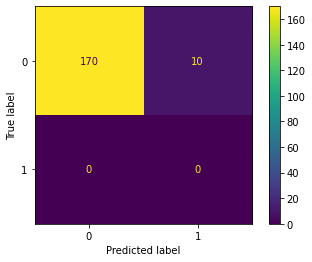

In [17]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import accuracy_score, precision_score, recall_score


cm = confusion_matrix(actual, pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
print("Accuracy:",accuracy_score(actual, pred))
print("Precision:",precision_score(actual, pred))
print("Recall",recall_score(actual, pred))
tn, fp, fn, tp = confusion_matrix(actual, pred).ravel()
print("Senstivity:",(tp/(tp+fn)))
print("Specificity:",(tn/(tn+fp)))

disp.plot()

In [18]:
print("True Positive Rate (TPR):",(tp/(tp+fn)))
print("False Positive Rate (FPR):",(fp/(fp+tn)))
# ROC - x=FPR  y=TPR
tpr = tp/(tp+fn)
fpr = fp/(fp+tn)

True Positive Rate (TPR): nan
False Positive Rate (FPR): 0.05555555555555555


<ipython-input-18-f11b0e0544ad>:1: RuntimeWarning: invalid value encountered in longlong_scalars
  print("True Positive Rate (TPR):",(tp/(tp+fn)))
<ipython-input-18-f11b0e0544ad>:4: RuntimeWarning: invalid value encountered in longlong_scalars
  tpr = tp/(tp+fn)


c:\users\hp\appdata\local\programs\python\python38-32\lib\site-packages\sklearn\metrics\_ranking.py:811: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  warnings.warn("No positive samples in y_true, "


[nan nan nan]
[0.         0.05555556 1.        ]
[2. 1. 0.]
Threshold value is: 2.0


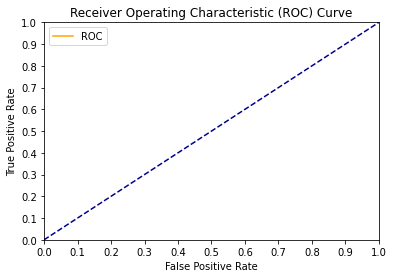

In [19]:
# https://towardsdatascience.com/a-simple-explanation-of-the-roc-curve-and-auc-64db32d75541
import sklearn.metrics as metrics
from sklearn.metrics import roc_curve
from sklearn.metrics import auc

def plot_roc_curve(fpr, tpr):
    plt.plot(fpr, tpr, color='orange', label='ROC')
    plt.plot([0, 1], [0, 1], color='darkblue', linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.0])
    plt.yticks([i/10.0 for i in range(11)])
    plt.xticks([i/10.0 for i in range(11)])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend()
    plt.show()
# fpr, tpr, thresholds = metrics.roc_curve(actual, pred, pos_label=2)

fpr, tpr, thresholds = roc_curve(actual, pred)
# roc_auc = auc(y_true, y_score)
print(tpr)
print(fpr)
print(thresholds)
# print(roc_auc)
optimal_idx = np.argmax(tpr - fpr)
optimal_threshold = thresholds[optimal_idx]
print("Threshold value is:", optimal_threshold)
plot_roc_curve(fpr, tpr)